#[Apache Spark 3.0.0 with Google Colab](http://apache.osuosl.org/spark/spark-3.0.0/)

**Author: MA Raza**

This is the working google collaboratory notebook example of setting up  recently release spark 3.0.0 in google colab. 

* Installing Java in the Google Colaboratory
* Setting up Spark 3.0 in the Google Colaboratory
* A test example

**References:**

1. http://apache.osuosl.org/spark/spark-3.0.0/
2. https://medium.com/@sushantgautam_930/apache-spark-in-google-collaboratory-in-3-steps-e0acbba654e6
3. https://notebooks.gesis.org/binder/jupyter/user/databricks-koalas-kuv5qckt/notebooks/docs/source/getting_started/10min.ipynb
4. https://medium.com/@amjadraza24/getting-started-spark3-0-0-with-google-colab-9796d350d78



# Setting up Spark 3.0.0 in the Google Colaboratory

This notebook comprises the instructions to run Sprak and pyspark in google colabboratory framework. 

We will be running the excises of  some basic functions on using koalas

We will install below programs

* Java 8
* spark-3.0.0
* Hadoop3.2 
* [Findspark](https://github.com/minrk/findspark)


This installs Apache Spark 3.0.0, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

Run below set of commands to install spark. 

**Change the location/version of spark version of your choice**

**[Apache Spark in Google Collaboratory In 3 steps.](https://medium.com/@sushantgautam_930/apache-spark-in-google-collaboratory-in-3-steps-e0acbba654e6)**

> Make sure the spark-version you are downloading is availbale on target link



In [1]:
# Run below commands
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!rm -rf spark-*
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz --overwrite
!pip install -q findspark

In [2]:

!ls -a

.   .config	 spark-3.0.1-bin-hadoop2.7
..  sample_data  spark-3.0.1-bin-hadoop2.7.tgz


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

## Spark Installation test
Lets test the installation of spark in our google colab environment. 

In [4]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Test the spark 
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])

df.show(3, False)


/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/session.py:381: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [5]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.0.1


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/*.zip" -d "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/"

Archive:  /content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip


In [7]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StopWordsRemover 
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext

In [8]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
TRAIN_FILE = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/train.csv"
TEST_DATA_FILE = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/test.csv"
TEST_LABEL = "/content/drive/My Drive/mgc_dataset/CS651Final/jigsaw-toxic-comment-classification-challenge/test_labels.csv"

train = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_DATA_FILE)
test_label =  pd.read_csv(TEST_LABEL)
print("training data shape",train.shape)
print("testing data shape",test_data.shape)
print("testing data label shape",test_label.shape)

training data shape (159571, 8)
testing data shape (153164, 2)
testing data label shape (153164, 7)


In [10]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [11]:
test_data.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [12]:
test_label.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

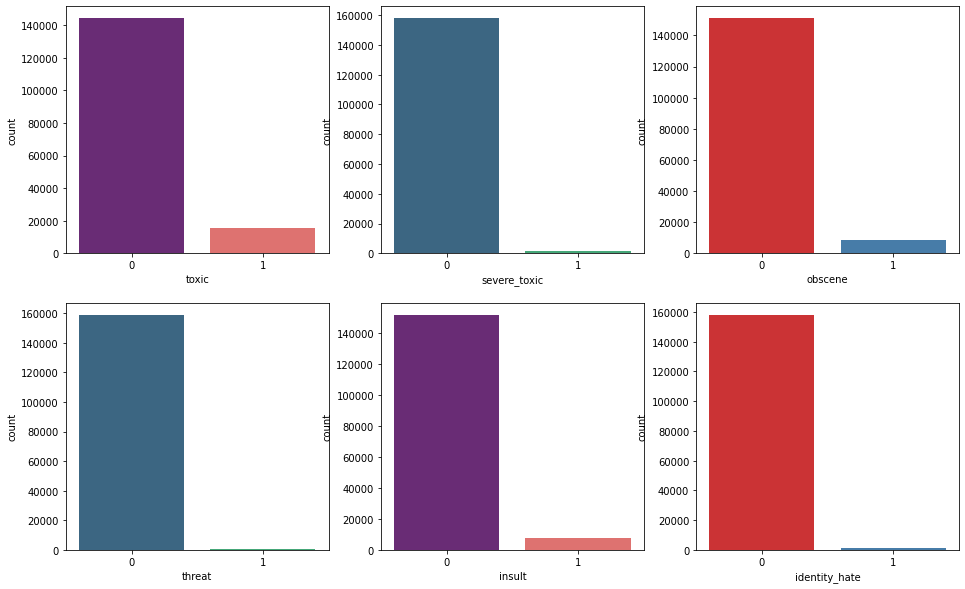

In [9]:
#distribution
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


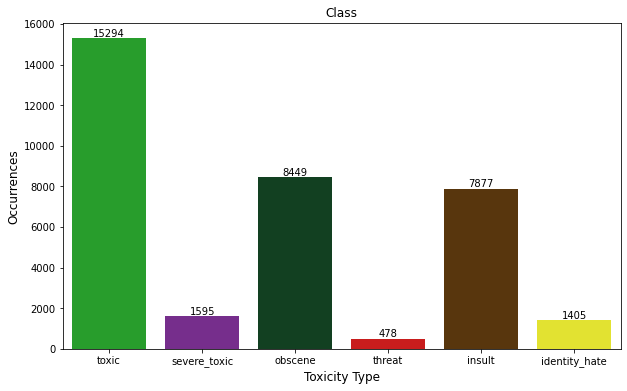

In [10]:
import numpy as np
colors_list = ["green", "purple","pine green","red", "brown","yellow", "blue"]
palette= sns.xkcd_palette(colors_list)
x=train.iloc[:,2:].sum()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.xlabel('Toxicity Type', fontsize = 12)
plt.ylabel('Occurrences', fontsize=12)
rects = ax.patches
labels = x.values

rowsums=train.iloc[:,2:].sum(axis=1)


    
train['clean']=(rowsums==0)

train['clean'].sum()
train['clean']=np.where(train['clean']==True,1,0)


for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


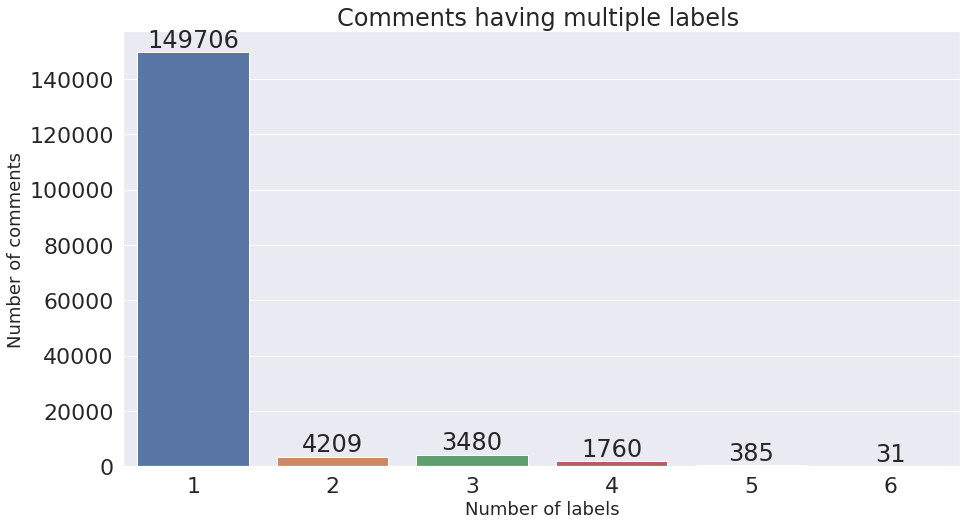

In [11]:
rowSums = train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [12]:
checkMissing = pd.DataFrame()
checkMissing['train'] = train.isnull().sum()
checkMissing['test_data'] = test_data.isnull().sum()
print(checkMissing)

               train  test_data
id                 0        0.0
comment_text       0        0.0
toxic              0        NaN
severe_toxic       0        NaN
obscene            0        NaN
threat             0        NaN
insult             0        NaN
identity_hate      0        NaN
clean              0        NaN


In [13]:
#No missing val
test_data['comment_text'].isnull().sum()

0

In [14]:
train.keys()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'clean'],
      dtype='object')

In [15]:
# # Stemming and Lemmatizing 
# import nltk

# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
train['comment_text'] = train['comment_text'].apply(stemming)





In [16]:
#lower case
train['comment_text'] = train['comment_text'].apply(lambda x:x.lower())
test_data['comment_text'] = test_data['comment_text'].apply(lambda x:x.lower())
# Get rid of the special charactors
train['comment_text'] = train['comment_text'].str.replace('\W', ' ')
test_data['comment_text'] = test_data['comment_text'].str.replace('\W', ' ')
#get rid of the digit
train['comment_text']  = train['comment_text'].str.replace(r'\d+','')
test_data['comment_text']  = test_data['comment_text'].str.replace(r'\d+','')
#get rid of the leading space
train['comment_text'] = train['comment_text'] .str.strip()
test_data['comment_text'] = test_data['comment_text'] .str.strip()
train.head(10)
#test_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,explan whi the edit made under my usernam hard...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,d aww he match this background colour i m see...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man i m realli not tri to edit war it ju...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,more i can t make ani real suggest on improv ...,0,0,0,0,0,0,1
4,0001d958c54c6e35,you sir are my hero ani chanc you rememb wh...,0,0,0,0,0,0,1
5,00025465d4725e87,congratul from me as well use the tool well ...,0,0,0,0,0,0,1
6,0002bcb3da6cb337,cocksuck befor you piss around on my work,1,1,1,0,1,0,0
7,00031b1e95af7921,your vandal to the matt shirvington articl has...,0,0,0,0,0,0,1
8,00037261f536c51d,sorri if the word nonsens was offens to you a...,0,0,0,0,0,0,1
9,00040093b2687caa,align on this subject and which are contrari t...,0,0,0,0,0,0,1


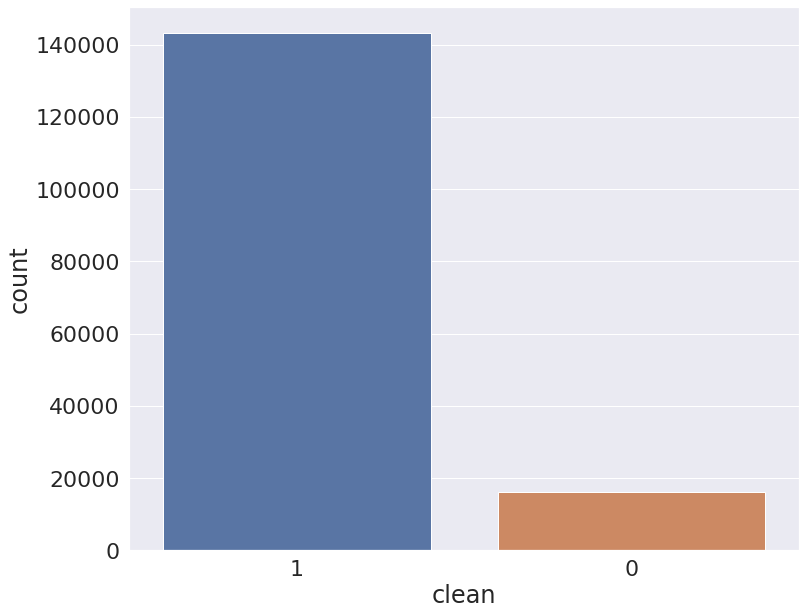

In [17]:
from pyspark.sql.functions import col, explode, array, lit
import random

train_binary_classification = pd.concat([train["id"],train["comment_text"],train["clean"]],axis=1)
train_binary_classification.head(10)


plt.figure(figsize=(12,10))
sns.countplot(x='clean', data=train_binary_classification, order=train_binary_classification['clean'].value_counts().index)




In [26]:
from imblearn.over_sampling import SMOTE
def handleImbalancedData(mode,train_classification,label):
  if(label=="clean"):
    count_class_1,count_class_0 = train_classification.clean.value_counts()
  elif(label=="toxic"):
    count_class_0,count_class_1 = train_classification.toxic.value_counts()
  elif(label=="severe_toxic"):
    count_class_0,count_class_1 = train_classification.severe_toxic.value_counts()
  elif(label=="obscene"):
    count_class_0,count_class_1 = train_classification.obscene.value_counts()
  elif(label=="threat"):
    count_class_0,count_class_1 = train_classification.threat.value_counts()
  elif(label=="insult"):
    count_class_0,count_class_1 = train_classification.insult.value_counts()
  elif(label=="identity_hate"):
    count_class_0,count_class_1 = train_classification.identity_hate.value_counts()



  print(count_class_1,count_class_0)

  # Divide by class
  
  df_class_0 = train_classification[train_classification[label] == 0]
  
  df_class_1 = train_classification[train_classification[label] == 1]

  if(mode=="undersampling"):
    # Under sampling majority label
    if(label=="clean"):
      df_class_1_under = df_class_1.sample(count_class_0)
      df_test_under = pd.concat([df_class_0, df_class_1_under], axis=0)
    if(label!="clean"):
      # Under sampling majority label
      df_class_0_under = df_class_0.sample(count_class_1)
      df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

    print('Random under-sampling:')
    #print(df_test_under.label.value_counts())
    # df_test_under.label.value_counts().plot(kind='bar', title='Count');
    df_test_under.head(10)
    return df_test_under
  elif(mode=="oversampling"):
    # over sampling majority label
    if(label=="clean"):
      df_class_0_over = df_class_0.sample(count_class_1,replace=True)
      df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)
    if(label!="clean"):
      df_class_1_over = df_class_1.sample(count_class_0,replace=True)
      df_test_over = pd.concat([df_class_0,df_class_1_over], axis=0)
    

    print('Random over-sampling:')

    # df_test_over.label.value_counts().plot(kind='bar', title='Count');
    # df_test_over.head(10)
    return df_test_over 


  else:
    return train_classification
  





TFIDF(t,d,D)=TF(t,d)⋅IDF(t,D). where IDF(t,D)=log(|D|+1/DF(t,D)+1).
TF is the number of times a term occurs within a document. This means that a term has different TF values for different documents of the corpus.
DF of a term is the number of documents having this term.Inverse Document Frequency - IDF

In [19]:

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [20]:
# import modules for feature transformation
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF,StopWordsRemover,IDF,Tokenizer
from pyspark.ml.feature import NGram
#Tokenize into words
tokenizer = Tokenizer().setInputCol("comment_text").setOutputCol("words")

#Remove stopwords
remover= StopWordsRemover().setInputCol("words").setOutputCol("filtered").setCaseSensitive(False)

#ngram = NGram(n=2, inputCol="filtered", outputCol="rawFeatures")

#For each sentence (bag of words),use HashingTF to hash the sentence into a feature vector. 
hashingTF = HashingTF().setNumFeatures(1000).setInputCol("filtered").setOutputCol("rawFeatures")

#Create TF_IDF features
idf = IDF().setInputCol("rawFeatures").setOutputCol("features").setMinDocFreq(0)

# Create a Logistic regression model
lr = LogisticRegression()

# Streamline all above steps into a pipeline
pipeline=Pipeline(stages=[tokenizer,remover,hashingTF,idf, lr])

In [21]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from sklearn.model_selection import train_test_split
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix

rebalanceDatasetTechnique = ["undersampling","oversampling","no technique"] 
for technique in rebalanceDatasetTechnique:
    print('**Processing {} on imbalanced data...**'.format(technique))

    df = handleImbalancedData(technique,train_binary_classification,"clean")
    X_train, X_test, y_train, y_test = train_test_split(pd.concat([df['id'],df['comment_text']],axis=1), df['clean'], test_size=0.2)

    training_spark_df_binary = spark.createDataFrame(data=pd.concat([X_train,y_train],axis=1),schema=["id","comment_text","label"])
    testing_spark_df_binary = spark.createDataFrame(data=pd.concat([X_test,y_test],axis=1),schema=["id","comment_text","label"])


    paramGrid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures,[1000,5000,10000])\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6])\
        .build()

    crossval = TrainValidationSplit(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator().setMetricName('areaUnderPR'), # set area Under precision-recall curve as the evaluation metric
                              # 80% of the data will be used for training, 20% for validation.
                              trainRatio=0.8)

    cvModel = crossval.fit(training_spark_df_binary)
    # Make predictions
    train_prediction = cvModel.transform(training_spark_df_binary)
    test_prediction = cvModel.transform(testing_spark_df_binary)

    pd_prediction = test_prediction.select("*").toPandas()
    actual = pd_prediction["label"].tolist()
    pred = pd_prediction["prediction"].tolist()
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    print(confusion_matrix(actual, pred))
    print("true positive rate",tp / (tp + fp))
    print("true negative rate",tn / (tn + fp))



    # compute the accuracy score on training data
    correct_train = train_prediction.filter(train_prediction.label == train_prediction.prediction).count()  
    accuracy_train = correct_train/train_prediction.count() # store the training accuracy score
    print('Training set accuracy {:.2%} data items: {}, correct: {}'.format(accuracy_train,train_prediction.count(), correct_train))
     
    # Caculate the accuracy score for the best model 
    correct_test = test_prediction.filter(test_prediction.label == test_prediction.prediction).count()  
    accuracy_test = correct_test/test_prediction.count()
    print('Testing set accuracy {:.2%} data items: {}, correct: {}'.format(accuracy_test, test_prediction.count(), correct_test))

**Processing undersampling on imbalanced data...**
143346 16225
Random under-sampling:
[[2731  475]
 [ 834 2450]]
true positive rate 0.8376068376068376
true negative rate 0.8518402994385527
Training set accuracy 84.80% data items: 25960, correct: 22013
Testing set accuracy 79.83% data items: 6490, correct: 5181
**Processing oversampling on imbalanced data...**
143346 16225
Random over-sampling:
[[26180  2554]
 [ 5141 23464]]
true positive rate 0.901837189637943
true negative rate 0.911115751374678
Training set accuracy 88.30% data items: 229353, correct: 202514
Testing set accuracy 86.58% data items: 57339, correct: 49644
**Processing no technique on imbalanced data...**
143346 16225
[[  320  2935]
 [   56 28604]]
true positive rate 0.9069406132090427
true negative rate 0.09831029185867896
Training set accuracy 90.92% data items: 127656, correct: 116065
Testing set accuracy 90.63% data items: 31915, correct: 28924


In [27]:

category = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


for col in category:
    print('**Processing {} comments...**'.format(col))

    train_multiple_classification = pd.concat([train["id"],train["comment_text"],train[col]],axis=1)
    df = handleImbalancedData("oversampling",train_multiple_classification,col)
    X_train, X_test, y_train, y_test = train_test_split(pd.concat([df['id'],df['comment_text']],axis=1), df[col], test_size=0.2)
    
    training_spark_df_multi = spark.createDataFrame(data=pd.concat([X_train,y_train],axis=1),schema=["id","comment_text","label"])
    testing_spark_df_multi = spark.createDataFrame(data=pd.concat([X_test,y_test],axis=1),schema=["id","comment_text","label"])


    paramGrid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures,[1000,5000,10000])\
        .addGrid(lr.regParam, [0.1, 0.01]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6])\
        .build()

    crossval = TrainValidationSplit(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator().setMetricName('areaUnderPR'), # set area Under precision-recall curve as the evaluation metric
                              # 80% of the data will be used for training, 20% for validation.
                              trainRatio=0.8)

    cvModel = crossval.fit(training_spark_df_multi)


    # Make predictions
    train_prediction_multi = cvModel.transform(training_spark_df_multi)
    test_prediction_multi = cvModel.transform(testing_spark_df_multi)


    pd_prediction = test_prediction_multi.select("*").toPandas()
    actual = pd_prediction["label"].tolist()
    pred = pd_prediction["prediction"].tolist()
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    print(confusion_matrix(actual, pred))
    print("true positive rate",tp / (tp + fp))
    print("true negative rate",tn / (tn + fp))


    # compute the accuracy score on training data
    correct_train_multi = train_prediction_multi.filter(train_prediction_multi.label == train_prediction_multi.prediction).count()  
    accuracy_train_multi = correct_train_multi/train_prediction_multi.count() # store the training accuracy score
    print('Training set accuracy {:.2%} data items: {}, correct: {}'.format(accuracy_train_multi,train_prediction_multi.count(), correct_train_multi))

    # Caculate the accuracy score for the best model 
    correct_test_multi = test_prediction_multi.filter(test_prediction_multi.label == test_prediction_multi.prediction).count()  
    accuracy_test_multi = correct_test_multi/test_prediction_multi.count()
    print('Testing set accuracy {:.2%} data items: {}, correct: {}'.format(accuracy_test_multi, test_prediction_multi.count(), correct_test_multi))

**Processing toxic comments...**
15294 144277
Random over-sampling:
[[23612  5078]
 [ 2318 26703]]
true positive rate 0.8402189987728517
true negative rate 0.8230045311955385
Training set accuracy 88.71% data items: 230843, correct: 204773
Testing set accuracy 87.18% data items: 57711, correct: 50315
**Processing severe_toxic comments...**
1595 157976
Random over-sampling:
[[28995  2628]
 [  108 31460]]
true positive rate 0.9229054212626144
true negative rate 0.9168959301774026
Training set accuracy 96.22% data items: 252761, correct: 243199
Testing set accuracy 95.67% data items: 63191, correct: 60455
**Processing obscene comments...**
8449 151122
Random over-sampling:
[[25108  4990]
 [ 1345 29006]]
true positive rate 0.8532180256500764
true negative rate 0.8342082530400691
Training set accuracy 90.63% data items: 241795, correct: 219142
Testing set accuracy 89.52% data items: 60449, correct: 54114
**Processing threat comments...**
478 159093
Random over-sampling:
[[30926   816]
 [  7